In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tifffile
!pip install segmentation-models-pytorch

In [3]:
cd /content/drive/My Drive/Projet SatMap/Implementation

/content/drive/My Drive/Projet SatMap/Implementation


In [0]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [0]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

import bin.data_opening as op
import bin.treatment as tr

import shapely.affinity
import matplotlib.pyplot as plt
import numpy as np

In [0]:
class Dataset(BaseDataset):    
    # Liste des images annotees
    IMAGES  = ('6010_1_2', '6010_4_2', '6010_4_4', '6040_1_0', '6040_1_3', '6040_2_2', 
               '6040_4_4', '6060_2_3', '6070_2_3', '6090_2_0', '6100_1_3', '6100_2_2',
               '6100_2_3', '6110_1_2', '6110_3_1', '6110_4_0', '6120_2_0', '6120_2_2',
               '6140_1_2', '6140_3_1', '6150_2_3', '6160_2_1', '6170_0_4', '6170_2_4',
               '6170_4_1')
    # ID des classes respectives : batiments, routes, arbres, rivieres, lacs 
    CLASSES = ('1', '3', '5', '7', '8')
    
    def __init__(self, classe=None, preprocessing=None):
        self.classe = self.CLASSES[classe]
        self.preprocessing = preprocessing
    
    def __getitem__(self, id):
        
        # Ouverture des fichiers
        data_opening = op.DataOpening()

        image, img_size = data_opening.get_tiff(self.IMAGES[id])
        x_max, y_min = data_opening.get_size(self.IMAGES[id])
        train_polygons = data_opening.get_polygons(self.IMAGES[id], self.classe)

        # Traitment des fichiers
        treatment = tr.Treatment()

        x_scaler, y_scaler = treatment.get_scalers(img_size, x_max, y_min)
        list_polygons = shapely.affinity.scale(train_polygons, xfact=x_scaler, yfact=y_scaler, origin=(0, 0, 0))
        mask = treatment.get_mask_polygons(img_size, list_polygons)

        # Modification des images
        image = treatment.get_img_rgb(image).astype('uint8')
        mask =  mask[:, :, np.newaxis]

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(x=0, image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        return image, mask

    def __len__(self):
        return len(self.IMAGES)

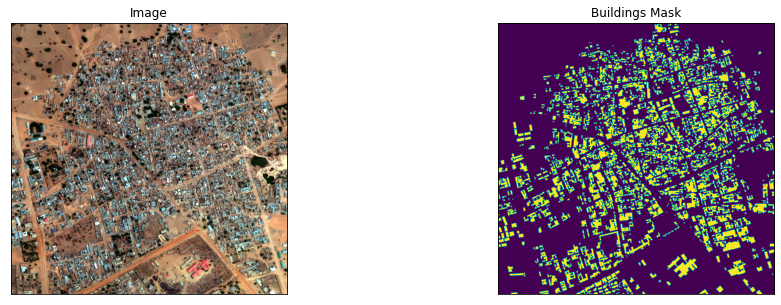

In [7]:
# Lets look at data we have

dataset = Dataset(classe=0)

image, mask = dataset[17] # get some sample

visualize(image=image, buildings_mask=mask.squeeze())

In [0]:
import albumentations as albu

In [0]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [0]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [0]:

#import segmentation_models_pytorch as smp
#import bin.trainer as train

#model = smp.Unet("resnet18", encoder_weights="imagenet", classes=1, activation=None)

#model_trainer = train.Trainer(model)
#model_trainer.start()

In [0]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['car']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

#model = smp.Unet("se_resnext50_32x4d", encoder_weights="imagenet", classes=1, activation=None)
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn("se_resnext50_32x4d", "imagenet")

In [0]:
train_dataset = Dataset(classe=0, preprocessing=preprocessing_fn)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [0]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()

metrics = [smp.utils.metrics.IoU(threshold=0.5)]

optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.0001)])

In [0]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
DEVICE = 'cuda'

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

In [16]:
# train model for 40 epochs

max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < train_logs['iou_score']:
        max_score = train_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/4 [00:02<?, ?it/s]


AttributeError: ignored